### Loading packages and functions

In [1]:
using LinearAlgebra
using Plots
using SIMD
using IRKGaussLegendre

PATH_SRC="../../src_simd/"
include(string(PATH_SRC,"IRKGL_SIMD.jl"))
using .IRKGL_SIMD   

In [2]:
PATH_ODES="../../ODEProblems/"

include(string(PATH_ODES,"Initial16Body.jl"))
include(string(PATH_ODES,"Nbody.jl"))

NbodyODE! (generic function with 2 methods)

In [3]:
PATH_SRC="../../src_seq/"

include(string(PATH_SRC,"IRKGL_SEQ.jl"))

using .IRKGL_SEQ   

In [4]:
#export JULIA_NUM_THREADS=4
Threads.nthreads()

4



## Definition of the N-body problem

In Nbody.jl below, the following functions are defined: NbodyEnergy(u,Gm), NbodyODE!(du,u,Gm,t), and NbodyODE1!(du,u,Gm,t), where

\begin{equation*}
u = 
\left(\begin{matrix}
q_1  & v_1\\
\vdots & \vdots \\
q_N  & v_N
\end{matrix}
\right) \in \mathbb{R}^{2 \times 3\times N}, \quad
Gm = (G\,  m_1, \ldots,G\,  m_N) \in \mathbb{R}^N.
\end{equation*}

The energy, as a function of the positions $q_1,\ldots,q_N \in \mathbb{R}^3$ and the velocities $v_1,\ldots,v_N \in \mathbb{R}^3$ of the $N$ bodies is:
\begin{equation*}
\begin{split}
\mathrm{Energy}(q_1,\ldots,q_N,v_1,\ldots,v_N) = 
\frac12 \sum_{i=1}^{N} m_i \, \|v_i\|^2
- G \sum_{1\leq i < j \leq N} \frac{m_i m_j}{\|q_i-q_j\|}.
\end{split}
\end{equation*}


The ODE system of the N-body problem,
as a function of the positions $q_1,\ldots,q_N \in \mathbb{R}^3$ and the velocities $v_1,\ldots,v_N \in \mathbb{R}^3$ of the $N$ bodies is:
\begin{equation*}
\begin{split}
\frac{d}{dt} q_i &= v_i, \\
\frac{d}{dt} v_i &= G\, 
\sum_{j \neq i} \frac{m_j}{\|q_j-q_i\|^3}\,
(q_j-q_i).
\end{split}
\end{equation*}
This system of ODEs can be writen in compact form as
\begin{equation*}
\frac{d u}{dt} = f(t,u,Gm)
\end{equation*}




##### <a href="#top">Back to the top</a>

## Initial value problem: 16-body problem

We consider $N=5$ bodies of the outer solar system: the Sun, Jupiter, Saturn, Uranus, and Neptune.
The initial values $u_{00}$ are taken from DE430, Julian day (TDB) 2440400.5 (June 28, 1969). 

In [6]:
u0, Gm, bodylist = Initial16Body(Float64)
q0=u0[:,:,1]
v0=u0[:,:,2]
dim=length(size(u0))

N = length(Gm)

show(bodylist)
E0=NbodyEnergy(u0,Gm)

["Sun" "Mercury" "Venus" "Mars" "Jupiter" "Saturn" "Uranus" "Neptune" "Pluto" "Ceres" "Pallas" "Vesta" "Iris" "Bamberga" "Earth" "Moon"]

-9.822698256164515e-12

### Integrazio luzea

In [7]:
t0 = 0.
dt = 3.
tF = 1e11
tF = 1e10
tF = 1e6   # 81.644963 sec
#tF = 1e9   # __ sec

prob = ODEProblem(NbodyODE!, u0, (t0,tF), Gm)

m = Int64(ceil((tF-t0)/(1000*dt)))

334

In [8]:
sols = []
iters = []
kmax=24

@time Threads.@threads for k in 0:kmax-1
   u0_ = copy(u0)
   prob_ = ODEProblem(NbodyODE!, u0_, (t0,tF), Gm);
   
   u0_[1] = u0[1] + k*1e-14
#   u0_[1] = u0[1] + kmax*1e-14*(rand()-0.5) 
  
alg=IRKGL_simd(s=8,initial_interp=1,dim=3,floatType=Float64, m=m, myoutputs=true)
solk,iterk=solve(prob_,alg,dt=dt, adaptive=false);    
    
    push!(sols,solk)    
#    push!(iters,iterk)
    
end

 81.644963 seconds (11.89 M allocations: 731.869 MiB, 0.17% gc time, 0.20% compilation time)


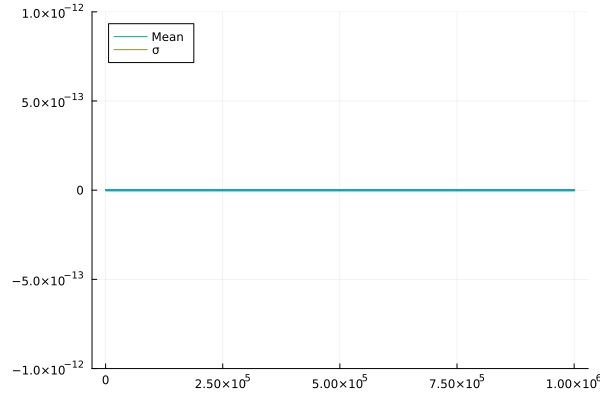

In [9]:
function energy_plot(sols; title="")
    tt = sols[1].t[2:end]
    yrange = (-1e-12,1e-12)
    P = 4331.89
    times = tt/P
    pl = plot(title=title, legend=:topleft, ylims=yrange)
    n = length(tt)
    errors = zeros(n)
    mean = zeros(n)
    sdev = zeros(n)
    energies = zeros(n)
    U = BigFloat.(u0)
    
    
    mean .= 0
    sdev .= 0
    for sl in sols
        U .= sl.u[1]
        E0 = NbodyEnergy(U,Gm)
        for i in 1:n
            U .= sl.u[i+1]
            errors[i] = NbodyEnergy(U,Gm)/E0 - 1
            mean[i] += errors[i]
            sdev[i] += errors[i]^2
        end 
        plot!(tt,  errors, linewidth=1, linealpha=0.3, label=:none)
    end
    kinv = 1/length(sols)
    @. mean = kinv * mean 
    @. sdev = sqrt(kinv*sdev-mean^2)
    plot!(tt, mean, linewidth=2,label="Mean")
    plot!(tt, sdev, linewidth=2,label="σ")
    plot!(tt, -sdev, linewidth=2, label=:none)
#    plot!(tt, 5.7e-18sqrt.(tt), label="5.7e-18*sqrt(t)")
#    plot!(tt, -5.7e-18sqrt.(tt), label=:none)
    return pl, tt, mean, sdev
end



pl0, tt, mean, sdev = energy_plot(sols);

display(pl0)

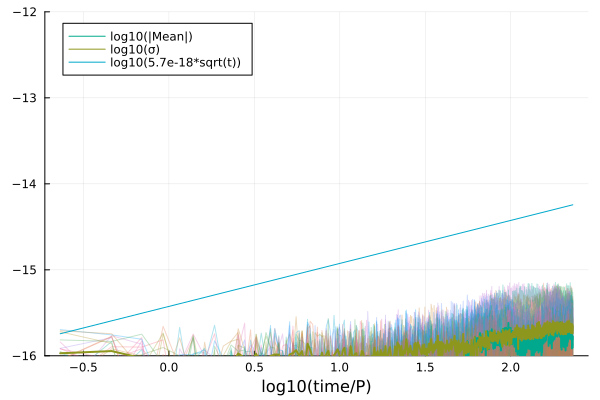

In [10]:


function energy_plot(sols; title="")
    tt = sols[1].t[2:end]
    yrange = (-16,-12)
    P = 4331.89
    logtimes = log10.(tt/P)
    pl = plot(title=title, ylims=yrange, legend=:topleft, xlabel="log10(time/P)")
    n = length(tt)
    errors = zeros(n)
    mean = zeros(n)
    sdev = zeros(n)
    energies = zeros(n)
    U = BigFloat.(u0)
    
    
    mean .= 0
    sdev .= 0
    for sl in sols
        U .= sl.u[1]
        E0 = NbodyEnergy(U,Gm)
        for i in 1:n
            U .= sl.u[i+1]
            errorsi = NbodyEnergy(U,Gm)/E0 - 1
            errors[i] = log10(abs(errorsi))
            mean[i] += errorsi
            sdev[i] += errorsi^2
        end 
        plot!(logtimes,  errors, linewidth=1, linealpha=0.3, label=:none)
    end
    kinv = 1/length(sols)
    @. mean = abs(kinv * mean) 
    @. sdev = log10(sqrt(kinv*sdev-mean^2))
    @. mean = log10(mean)
    plot!(logtimes, mean, linewidth=2, label="log10(|Mean|)")
    plot!(logtimes, sdev, linewidth=2, label="log10(σ)")
    plot!(logtimes, log10.(5.7e-18sqrt.(tt)), label="log10(5.7e-18*sqrt(t))")
    return pl, tt, mean, sdev
end



pl0, tt, mean, sdev = energy_plot(sols);

display(pl0)